## Import and Setup
This is a starter notebook to deploy the endpoint and be able to get mask predictions from your local machine.

In [12]:
import sagemaker
import boto3
import time
from PIL import Image
import io
import cv2
import matplotlib.pyplot as plt
from site_tools import category2mask
from site_tools import call_endpoint_with_local_image

# Role to connect to sagemaker
role='arn:aws:iam::395166463292:role/service-role/AmazonSageMaker-ExecutionRole-20200714T182988'

# reference correct profile saved in .aws/credentials and .aws/config
profile = 'crayon-site'
region_name='us-east-2'
bucket = 'st-crayon-dev'
prefix = 'sagemaker/labelbox/'

from botocore.exceptions import ProfileNotFound

# Sets the default boto3 profile instead of the usual default profile
try:
    boto3.setup_default_session(profile_name=profile)
except ProfileNotFound:
    print("crayon-site profile not found. Using default aws profile.")


session = boto3.session.Session(profile_name = profile, region_name = region_name)
sess = sagemaker.Session(session,default_bucket=bucket)
sagemaker_client = session.client('sagemaker')
print(sess.boto_session)

Session(region_name='us-east-2')


## Create Endpoint from current configuration
Actually create the Sagemaker endpoint after specifying the instances.

In [5]:
# Endpoint 
endpoint_config_name = f'ss-labelbox-1024-config-v2'
# 
endpoint_name = f'ss-labelbox-1024-size-1024-v3'

create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

arn:aws:sagemaker:us-east-2:395166463292:endpoint/ss-labelbox-1024-size-1024-v3
Status: Creating


### Wait for model deployment
once model is deployed Status changes to 'InService'

In [9]:
while status=='Creating':
    time.sleep(60)
    resp = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

Status: InService
Arn: arn:aws:sagemaker:us-east-2:395166463292:endpoint/ss-labelbox-1024-size-1024-v3
Status: InService


## Test local images

In [33]:
img_path = 'wmdc7030_pottsvillepa_-_mapping_-_DJI_5219.JPG'
anno_path = 'wmdc7030_pottsvillepa_-_mapping_-_DJI_5219.png'
chipsize=1024
client =  session.client('runtime.sagemaker')

In [31]:
anno_prediction = call_endpoint_with_local_image(
            img_path, sagemaker_client, endpoint_name, chipsize
        )

In [ ]:
img_orig = Image.open(img_path)
anno_truth = category2mask(np.array(Image.open(anno_path)))
anno_prediction = category2mask(anno_prediction)

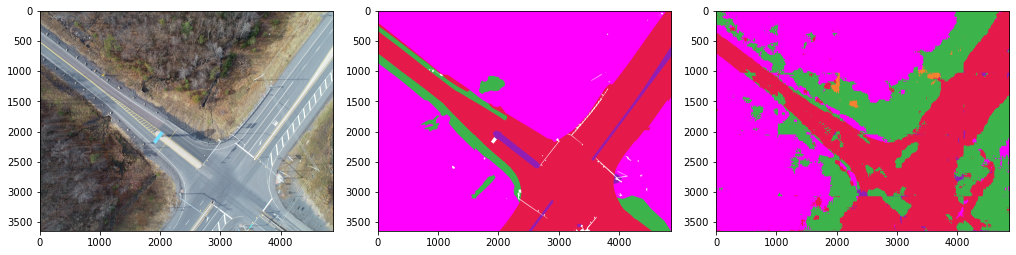

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(14, 8), constrained_layout=True)
ax[0].imshow(img_orig)
ax[1].imshow(anno_truth)
ax[2].imshow(anno_prediction)

## Delete Endpoint

This frees up the endpoint resources (or you are charged ongoing costs for the instance running the endpoint).

In [11]:
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'b2d93d38-c0e1-4d1d-8ca1-57477c96e06d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b2d93d38-c0e1-4d1d-8ca1-57477c96e06d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 12 Aug 2020 02:11:16 GMT'},
  'RetryAttempts': 0}}